In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from  multimodemodel import (
    StaggeredGrid,
    State,
    Variable,
    Parameters,
    integrate,
    adams_bashforth3,
    pressure_gradient_i,
    pressure_gradient_j,
    divergence_i,
    divergence_j,
)
from multimodemodel.API_implementation import (
    DomainState,
    GeneralSolver,
    RegularSplitMerger,
    BorderState,
    BorderMerger,
    Tail,
    ParameterSplit,
    GridSplit,
)
from multimodemodel import diag
from dask.distributed import Client, performance_report, get_worker, wait
from dask import delayed
from time import sleep
from copy import copy
from itertools import cycle

/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
parts = 4
domains_per_worker = 1
client = Client(
    n_workers=parts//domains_per_worker,
    threads_per_worker=domains_per_worker+1
)
workers = [k for k in client.scheduler_info()["workers"]]
workers = [
    workers[i // domains_per_worker]
    for i in range(domains_per_worker*len(workers))
]
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60922,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:60938,Total threads: 2
Dashboard: http://127.0.0.1:60941/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:60928,


(50000, 100)


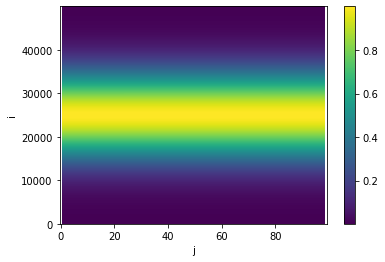

In [3]:
def staggered_grid(shape, grid_spacing):
    nx, ny = shape
    dx, dy = grid_spacing
    x = np.arange(0.0, dx * nx, dx)
    y = np.arange(0.0, dy * ny, dy)
    return StaggeredGrid.cartesian_c_grid(x, y)

nx, ny = 50000, 100
dx, dy = 1., 1.
n_step = 500

parameter = Parameters(H=1.0)

grid = staggered_grid((nx, ny), (dx, dy))

def initial_condition(staggered_grid, parameter):
    nx, ny = staggered_grid.u.len_x, staggered_grid.u.len_y
    u = np.zeros((nx, ny))
    v = np.zeros((nx, ny))
    x, y = staggered_grid.eta.x, staggered_grid.eta.y
    eta = np.exp(
        -((x - x.mean()) ** 2 + (y - y.mean()) ** 2)
        / (x.max() // 5) ** 2
    )

    initial_state = State(
        u=Variable(u, staggered_grid.u),
        v=Variable(v, staggered_grid.v),
        eta=Variable(eta, staggered_grid.eta),
    )

    return DomainState.make_from_State(
        initial_state, history=deque([], maxlen=3), parameter=parameter, it=0, id=0
    )

def non_rotating_swe(state, params):
    rhs = (
        pressure_gradient_i(state, params)
        + pressure_gradient_j(state, params)
        + divergence_i(state, params)
        + divergence_j(state, params)
    )
    return rhs

def get_dt(grid, parameter):
    dx = min(grid.dx.min(), grid.dy.min())
    c = np.sqrt(parameter.H * parameter.g)
    return 0.15 * dx / c

initial_condition(grid, parameter).eta.as_dataarray.plot()
print(initial_condition(grid, parameter).eta.data.shape)

In [4]:
def _make_borders(base, width, dim):
    result = (
        BorderState.create_border(base, width, False, dim),
        BorderState.create_border(base, width, True, dim),
    )
    return result

def _pint(gs, domain, borders, left_neighbor_borders, right_neighbor_borders, dim):
    result = (
        gs.partial_integration(
            border=borders[0],
            domain=domain,
            neighbor_border=left_neighbor_borders[1],
            direction=False,
            dim=dim,
        ),
        gs.partial_integration(
            border=borders[1],
            domain=domain,
            neighbor_border=right_neighbor_borders[0],
            direction=True,
            dim=dim,
        ),
    )
    return result

def _int(gs, domain):
    new_domain = gs.integration(domain)
    return new_domain

def _stitch(t, domain, borders):
    return t.stitch(domain, borders, dims=(0,))

def without_stripping(initial_state, dt, client, parts=4, final_merge=True):
    border_width = 2
    dim = (0,)
    splitter = RegularSplitMerger(parts, dim)
    [tailor] = client.scatter([Tail()], broadcast=True)
    [gs] = client.scatter(
        [GeneralSolver(
            solution=non_rotating_swe,
            schema=adams_bashforth3,
            step=dt
        )],
        broadcast=True,
    )
    
    domains = initial_state.split(splitter)
    
    domain_stack = deque(
        [[client.scatter(d, workers=w) for d, w in zip(domains, cycle(workers))]],
        maxlen=2
    )
    wait(domain_stack[-1])
    border_stack = deque(
        [[client.submit(_make_borders, sub, border_width, dim[0]) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    wait(border_stack[-1])
    domain_owners = [client.who_has(d)[d.key] for d in domain_stack[-1]]
    
    for _ in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, (s, w) in enumerate(zip(domain_stack[-1], domain_owners)):
            worker_of_s = w
            borders = client.submit(
                _pint, gs, s,
                border_stack[-1][i],
                border_stack[-1][i - 1],
                border_stack[-1][(i + 1) % (splitter.parts)],
                dim[0],
                workers=worker_of_s
            )
            new_s = client.submit(_int, gs, s, workers=worker_of_s)
            new_subdomains.append(
                client.submit(_stitch, tailor, new_s, borders, workers=worker_of_s)
            )
            new_borders.append(borders)

        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)
        
    del gs
    del tailor
    if final_merge:
        return DomainState.merge(client.gather(domain_stack[-1]), splitter)
    else:
        return domain_stack[-1]

In [5]:
def _pint_stripped(gs, domain, borders, left_neighbor_borders, right_neighbor_borders, dim, frozen_objs, final_merge=True):
    res = _pint(
        gs,
        domain.populate(frozen_objs),
        (borders[0].populate(frozen_objs), borders[1].populate(frozen_objs)),
        (left_neighbor_borders[0].populate(frozen_objs), left_neighbor_borders[1].populate(frozen_objs)),
        (right_neighbor_borders[0].populate(frozen_objs), right_neighbor_borders[1].populate(frozen_objs)),
        dim
    )
    return tuple(r.strip({}) for r in res)

def _int_stripped(gs, domain, frozen_objs):
    d = domain.populate(frozen_objs)
    new = _int(gs, d)
    return new.strip({})

def _stitch_stripped(t, domain, borders, frozen_objs):
    d = domain.populate(frozen_objs)
    brds = tuple(b.populate(frozen_objs) for b in borders)
    new = _stitch(t, d, brds)
    return new.strip({})

def with_stripping(initial_state, dt, client, parts=4, final_merge=True):
    border_width = 2
    dim = (0,)
    splitter = RegularSplitMerger(parts, dim)
    [tailor] = client.scatter([Tail()], broadcast=True)
    [gs] = client.scatter(
        [GeneralSolver(
            solution=non_rotating_swe,
            schema=adams_bashforth3,
            step=dt
        )],
        broadcast=True,
    )
    frozen_objs = dict()
    
    domains = initial_state.split(splitter)
    borders = tuple(_make_borders(sub, border_width, dim[0]) for sub in domains)
    
    stripped_domains = tuple(s.strip(frozen_objs) for s in domains)
    stripped_borders = tuple(tuple(b.strip(frozen_objs) for b in bt) for bt in borders)
    
    [fo] = client.scatter([frozen_objs], broadcast=True)
    domain_stack = deque([[client.scatter(d, workers=w) for d, w in zip(stripped_domains, cycle(workers))]], maxlen=2)
    wait(domain_stack[-1])
    border_stack = deque(
        [client.scatter(stripped_borders)],
        maxlen=2,
    )
    wait(border_stack[-1])
    domain_owners = [client.who_has(d)[d.key] for d in domain_stack[-1]]

    for i in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, (s, w) in enumerate(zip(domain_stack[-1], domain_owners)):
            worker_of_s = w
            borders = client.submit(
                _pint_stripped, gs, s,
                border_stack[-1][i],
                border_stack[-1][i - 1],
                border_stack[-1][(i + 1) % (splitter.parts)],
                dim[0],
                fo,
                workers=worker_of_s
            )
            new_s = client.submit(_int_stripped, gs, s, fo, workers=worker_of_s)
            new_subdomains.append(
                client.submit(_stitch_stripped, tailor, new_s, borders, fo, workers=worker_of_s)
            )
            new_borders.append(borders)

        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)
        
    del gs
    del tailor
    del fo
    if final_merge:
        return DomainState.merge(
            tuple(d.populate(frozen_objs) for d in client.gather(domain_stack[-1])),
            splitter
        )        
    else:
        return domain_stack[-1]

In [6]:
def classic_API(initial_state, dt, n):
    state = State(initial_state.u, initial_state.v, initial_state.eta)
    for i, next_state in enumerate(integrate(
        state,
        initial_state.parameter,
        RHS=non_rotating_swe,
        step=dt,
        time=n*dt,
        scheme=adams_bashforth3,
    )):
        if i % 100 == 0:
            print(f"i: {i}")
    return next_state

# numba warm up
def warm_up(grid, parameter):
    oracle = classic_API(
        initial_condition(grid, parameter),
        get_dt(grid.u, parameter),
        n=1
    )

client.run(warm_up, grid, parameter)

/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)
/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)
/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)
/Users/mclaus/mambaforge/envs/test_mm_distributed/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


{'tcp://127.0.0.1:60936': None,
 'tcp://127.0.0.1:60938': None,
 'tcp://127.0.0.1:60939': None,
 'tcp://127.0.0.1:60945': None}

In [7]:
%%time
with performance_report(filename="without_stripping.html"):
    result = without_stripping(
        initial_condition(grid, parameter),
        get_dt(grid.u, parameter),
        client,
        parts,
    )

CPU times: user 1min 11s, sys: 8.45 s, total: 1min 20s
Wall time: 1min 58s


In [8]:
%%time
with performance_report(filename="with_stripping.html"):
    result = with_stripping(
        initial_condition(grid, parameter),
        get_dt(grid.u, parameter),
        client,
        parts,
    )

CPU times: user 1min 14s, sys: 7.76 s, total: 1min 22s
Wall time: 1min 55s


In [9]:
%%prun -s cumtime -D pi.prof
without_stripping(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
    client,
    parts,
    final_merge=False,
)

 
*** Profile stats marshalled to file 'pi.prof'. 


         147823750 function calls (147757628 primitive calls) in 100.496 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  101.873  101.873 {built-in method builtins.exec}
        1    0.088    0.088  101.872  101.872 <string>:1(<module>)
        1    0.062    0.062  101.672  101.672 3786325674.py:34(without_stripping)
     6004    2.577    0.000   99.717    0.017 client.py:1473(submit)
     6004    0.258    0.000   96.549    0.016 client.py:2585(_graph_to_futures)
     6004    0.106    0.000   93.550    0.016 client.py:2529(_get_computation_code)
     6004    0.017    0.000   93.301    0.016 inspect.py:1018(getsource)
     6004    0.083    0.000   93.265    0.016 inspect.py:997(getsourcelines)
     6004    0.150    0.000   61.687    0.010 inspect.py:809(findsource)
    12008   24.124    0.002   55.219    0.005 inspect.py:727(getmodule)
     6004    0.089    0.000   31.942    0.005 inspect.py:69